In the last model, I tweeked parameters to get an idea on how well the validation set was performing vs the training set. The validation data doesn't seem to mirror the training set like it did in previous models. I believe that was due to data leakage in the way I created the training data. In this model, I will create validation and test sets that come from different videos, so data leakage shouldn't be an issue. In this iteration, the validation set will be created from two different videos I already have recorded. The test will be the original test set that I created from a separate video. The sets will be on the small side, but I will record more videos later for labeling if needed. The first run of the model will be with non augmented images to see how well adding the flipped images and new sets compare.

In [1]:
%load_ext autoreload
%autoreload 2
import project_utils_multi

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
# tf.get_logger().setLevel('INFO')
# tf.autograph.set_verbosity(1)
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device. Error.')
    pass

from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from random import randint
import numpy as np

RANDOM_SEED = 0
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 100
LEARNING_RATE = 0.0001
ES_PATIENCE = 10
ES_RESTORE_WEIGHTS = True
PLAY_VIDEOS = False

In [2]:
df_train = project_utils_multi.load_image_dataframes('./data/train/', 'annotations.json')
display(df_train)

,id,confidence,y1,x1,y2,x2
0,00001.jpg,1.0,152.0,140.0,397.0,346.0
1,00002.jpg,1.0,144.0,140.0,403.0,345.0
2,00003.jpg,1.0,142.0,138.0,402.0,346.0
3,00004.jpg,1.0,144.0,140.0,405.0,344.0
4,00005.jpg,1.0,141.0,140.0,407.0,344.0
...,...,...,...,...,...,...
5995,05996.jpg,0.0,0.0,0.0,0.0,0.0
5996,05997.jpg,0.0,0.0,0.0,0.0,0.0
5997,05998.jpg,0.0,0.0,0.0,0.0,0.0
5998,05999.jpg,0.0,0.0,0.0,0.0,0.0


In [3]:
df_validation = project_utils_multi.load_image_dataframes('./data/validation/', 'annotations.json')
display(df_validation)

,id,confidence,y1,x1,y2,x2
0,00001.jpg,1.0,439.0,600.0,630.0,804.0
1,00002.jpg,1.0,280.0,466.0,467.0,650.0
2,00003.jpg,1.0,204.0,455.0,409.0,636.0
3,00004.jpg,1.0,218.0,380.0,412.0,538.0
4,00005.jpg,1.0,220.0,405.0,423.0,568.0
...,...,...,...,...,...,...
305,00306.jpg,0.0,0.0,0.0,0.0,0.0
306,00307.jpg,0.0,0.0,0.0,0.0,0.0
307,00308.jpg,0.0,0.0,0.0,0.0,0.0
308,00309.jpg,0.0,0.0,0.0,0.0,0.0


In [4]:
df_test = project_utils_multi.load_image_dataframes('./data/test/', 'annotations.json')
display(df_test)

,id,confidence,y1,x1,y2,x2
0,00001.jpg,1.0,220.0,252.0,411.0,437.0
1,00002.jpg,1.0,217.0,241.0,402.0,432.0
2,00003.jpg,1.0,229.0,252.0,416.0,443.0
3,00004.jpg,1.0,243.0,317.0,425.0,487.0
4,00005.jpg,1.0,274.0,332.0,457.0,510.0
...,...,...,...,...,...,...
219,00220.jpg,0.0,0.0,0.0,0.0,0.0
220,00221.jpg,0.0,0.0,0.0,0.0,0.0
221,00222.jpg,0.0,0.0,0.0,0.0,0.0
222,00223.jpg,0.0,0.0,0.0,0.0,0.0


In [5]:
train_datagen= project_utils_multi.create_data_generators(df_train, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/train/', seed=RANDOM_SEED)
validation_datagen = project_utils_multi.create_data_generators(df_validation, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/validation/', seed=RANDOM_SEED)
test_datagen = project_utils_multi.create_data_generators(df_test, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/test/', seed=RANDOM_SEED)
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(train_datagen, num_to_iter=250))
    display(project_utils_multi.play_images_from_sequence_datagen(validation_datagen, num_to_iter=1))
    display(project_utils_multi.play_images_from_sequence_datagen(test_datagen, num_to_iter=1))

In [6]:
pos_neg = project_utils_multi.get_negative_positive_count('./data/train/', 'annotations.json')
print('Total Examples: ', pos_neg['positive'] + pos_neg['negative'])
print('Total positive: ', pos_neg['positive'])
print('Total negative: ', pos_neg['negative'])
print('Train positive: ', train_datagen.get_positive_count())
print('Train negative: ', train_datagen.get_negative_count())
print('Validation positive: ', validation_datagen.get_positive_count())
print('Validation negative: ', validation_datagen.get_negative_count())
print('Test positive: ', test_datagen.get_positive_count())
print('Test negative: ', test_datagen.get_negative_count())

Total Examples:  6000
Total positive:  5399
Total negative:  601
Train positive:  5399
Train negative:  601
Validation positive:  262
Validation negative:  48
Test positive:  202
Test negative:  22


In [7]:
vgg = keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=keras.layers.Input(shape=(224, 224, 3)))
vgg.trainable = False

flatten = vgg.output
flatten = keras.layers.Flatten()(flatten)

hidden = keras.layers.Dense(1024, activation='relu')(flatten)

confHead = keras.layers.Dense(1, activation='sigmoid', name='confidence_output')(hidden)
bbHead = keras.layers.Dense(4, activation='linear', name='bounding_output')(hidden)

model = keras.models.Model(inputs=vgg.input, outputs=[confHead, bbHead])
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=opt, metrics=[[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()], [project_utils_multi.IOU_Metric()]])#, run_eagerly=True)


# es = EarlyStopping(monitor='val_bounding_output_iou__metric', mode='max', verbose=1, patience=ES_PATIENCE, restore_best_weights=ES_RESTORE_WEIGHTS)
es = EarlyStopping(monitor='val_bounding_output_loss', mode='min', verbose=1, patience=ES_PATIENCE, restore_best_weights=ES_RESTORE_WEIGHTS)

history = model.fit(train_datagen, 
                    steps_per_epoch=train_datagen.get_length() // BATCH_SIZE,
                    validation_data=validation_datagen, 
                    validation_steps = validation_datagen.get_length() // BATCH_SIZE,
                    epochs=EPOCHS, 
                    callbacks=[es])


80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/100
187/187 [==============================] - 49s 196ms/step - loss: 109398.8951 - confidence_output_loss: 0.1059 - bounding_output_loss: 109398.8020 - confidence_output_binary_accuracy: 0.8955 - confidence_output_auc: 0.4652 - bounding_output_iou__metric: 0.1107 - val_loss: 27620.6270 - val_confidence_output_loss: 0.1537 - val_bounding_output_loss: 27620.4746 - val_confidence_output_binary_accuracy: 0.8438 - val_confidence_output_auc: 0.6801 - val_bounding_output_iou__metric: 0.4116
Epoch 2/100
187/187 [==============================] - 36s 194ms/step - loss: 31262.0484 - confidence_output_loss: 0.0930 - bounding_output_loss: 31261.9564 - confidence_output_binary_accuracy: 0.9069 - confidence_output_auc: 0.4453 - bounding_output_iou__metric: 0.2456 - val_loss: 26584.5352 - val_confidence_output_loss: 0.1667 - val_bounding_output_loss: 26584.3672 - val_confidence_output_binary_accuracy: 0.8333 - val_confidence_ou

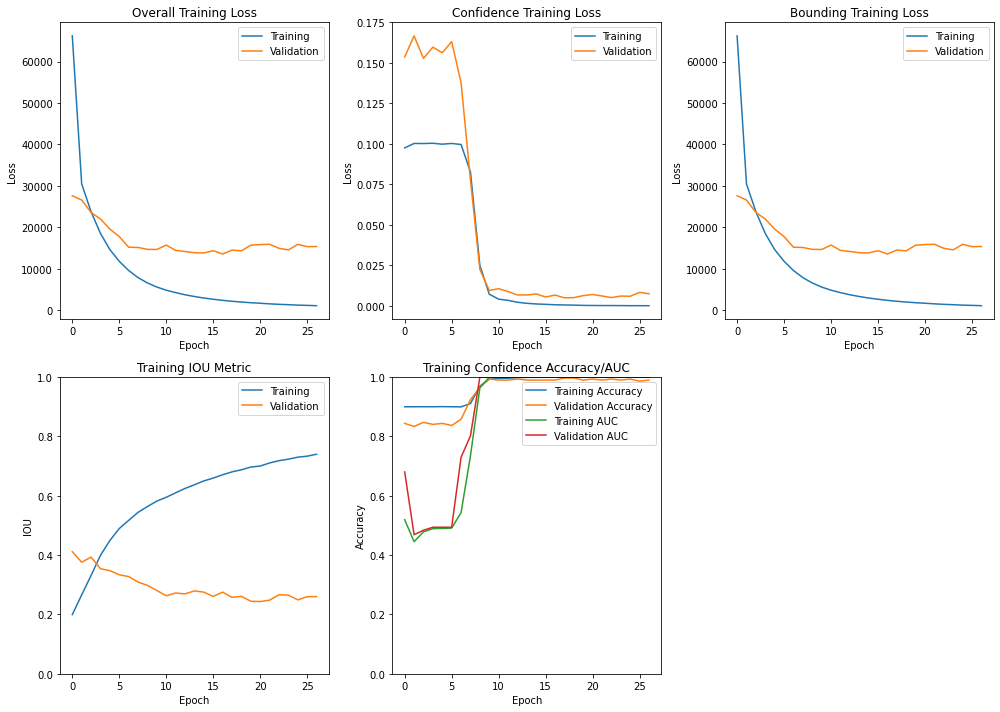

7/7 [==============================] - 1s 180ms/step - loss: 13295.2959 - confidence_output_loss: 0.0050 - bounding_output_loss: 13295.2900 - confidence_output_binary_accuracy: 0.9911 - confidence_output_auc: 0.9998 - bounding_output_iou__metric: 0.2885
Training Loss: 2230.901611328125
Training IOU: 0.6776391863822937
Validation Loss: 13720.4501953125
Validation IOU: 0.2701534628868103
Test Loss: 13295.2958984375
Test IOU: 0.2884863018989563


In [8]:
project_utils_multi.plot_history(history)
train_results = model.evaluate(train_datagen)
validation_results = model.evaluate(validation_datagen)
test_results = model.evaluate(test_datagen)
print('Training Loss: {}\nTraining IOU: {}'.format(train_results[0], train_results[-1]))
print('Validation Loss: {}\nValidation IOU: {}'.format(validation_results[0], validation_results[-1]))
print('Test Loss: {}\nTest IOU: {}'.format(test_results[0], test_results[-1]))
project_utils_multi.write_results('./history.txt', model, history, train_datagen, validation_datagen)

In [9]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(train_datagen, model=model, num_to_iter=100))

In [10]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(validation_datagen, model=model, num_to_iter=1))

In [11]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(test_datagen, model=model, num_to_iter=1))

In [12]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_video('../../data/original/test_videos/hand_signs_webcam.mp4', model=model))

In [13]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_video('../../data/original/test_videos/hand_signs_hand_only.mp4', model=model))